In [1]:
%matplotlib inline
# import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import videoUtility
import numpy.linalg as la
import scipy.io

import sys

# import sparsify
import sparsify_PyTorch
import utility

import torch
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor
from torch.utils.data import DataLoader, Dataset


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

dataset_size = 1000
# take first <dataset_size> images as a demo dataset
images = training_data.data[:dataset_size] # <dataset_size> x 28 x 28


/home/derek/anaconda3/envs/py11-torch2-cuda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


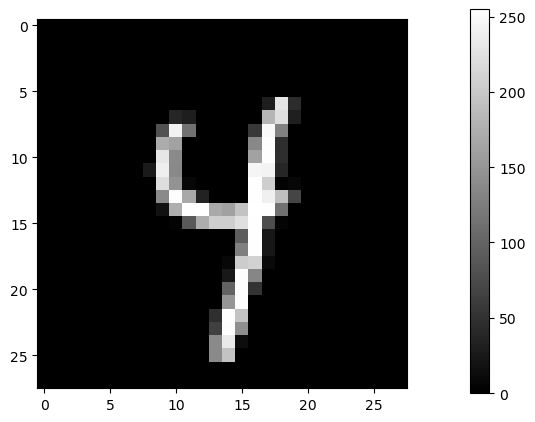

In [3]:
utility.imshow(images[26,:,:])

In [4]:
torch.cuda.set_device(0) #use GPU 1
# Now let's start to learn sparse coding basis
# Effective dimensionality is about 200, let's make it 20 times overcomplete.
# Layer1 sparse coding initialization

xdim = 6 #Patch size
ydim = 6 #Patch size
BASIS1_NUM = 500
BASIS1_SIZE = [xdim*ydim, BASIS1_NUM]
BATCH_SIZE = 20

basis1 = torch.randn(BASIS1_SIZE).cuda()
basis1.div_(basis1.norm(2,0)) # so every base vector's norm = 1

lambd = 1.0
STEPS = 30000

ACT_HISTORY_LEN = 300
HessianDiag = torch.zeros(BASIS1_NUM).cuda()
ActL1 = torch.zeros(BASIS1_NUM).cuda()
signalEnergy = 0.
noiseEnergy = 0.

edgeBuff = 2
spRange_t = images.shape[0]
spRange_x = images.shape[1] - xdim - edgeBuff * 2
spRange_y = images.shape[2] - ydim - edgeBuff * 2
I = np.zeros([xdim*ydim,BATCH_SIZE]).astype('int')
totalSteps1 = 0

In [5]:

# for i in range(totalSteps1,STEPS):
#     for j in range(BATCH_SIZE):
#         sIdx = np.floor(np.random.rand()*spRange_t).astype(int)
#         xIdx = np.floor(np.random.rand()*spRange_x + edgeBuff).astype(int)
#         yIdx = np.floor(np.random.rand()*spRange_y + edgeBuff).astype(int)
#         I[:,j] = images[sIdx,xIdx:xIdx+xdim,yIdx:yIdx+ydim].reshape([xdim*ydim])
#     I_cuda = torch.from_numpy(I).cuda()
    
#     #Sparse Coefficients Inference by ISTA
#     #For positive-only codes, use ISTA
#     #For positive-negative codes, use ISTA_PN 
#     ahat, Res = sparsify_PyTorch.ISTA_PN(I_cuda, basis1, lambd, 1000)
#     #ahat, Res = sparsify_PyTorch.ISTA(I_cuda, basis1, 0.03, 1000)
    
#     #Statistics Collection
#     ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat.abs().mean(1)/ACT_HISTORY_LEN
#     HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat,2).mean(1)/ACT_HISTORY_LEN
    
#     signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_cuda,2).sum()/ACT_HISTORY_LEN
#     noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res,2).sum()/ACT_HISTORY_LEN
#     snr = signalEnergy/noiseEnergy
    
#     #Dictionary Update
#     totalSteps1 = totalSteps1 + 1
#     basis1 = sparsify_PyTorch.quadraticBasisUpdate(basis1, Res, ahat, 0.001, HessianDiag, 0.01)
    
#     #Print Information
#     if i % 100 == 0:
#         print(totalSteps1, snr, HessianDiag.min(), HessianDiag.max(), ActL1.min(), ActL1.max(), ActL1.sum())

# basis1_host = basis1.cpu().numpy()
# np.savez("basis1_MNIST_first1000.npz", basis1 = basis1_host)

In [6]:
basis1_host = np.array(np.load("basis1_MNIST_first1000.npz")['basis1'])

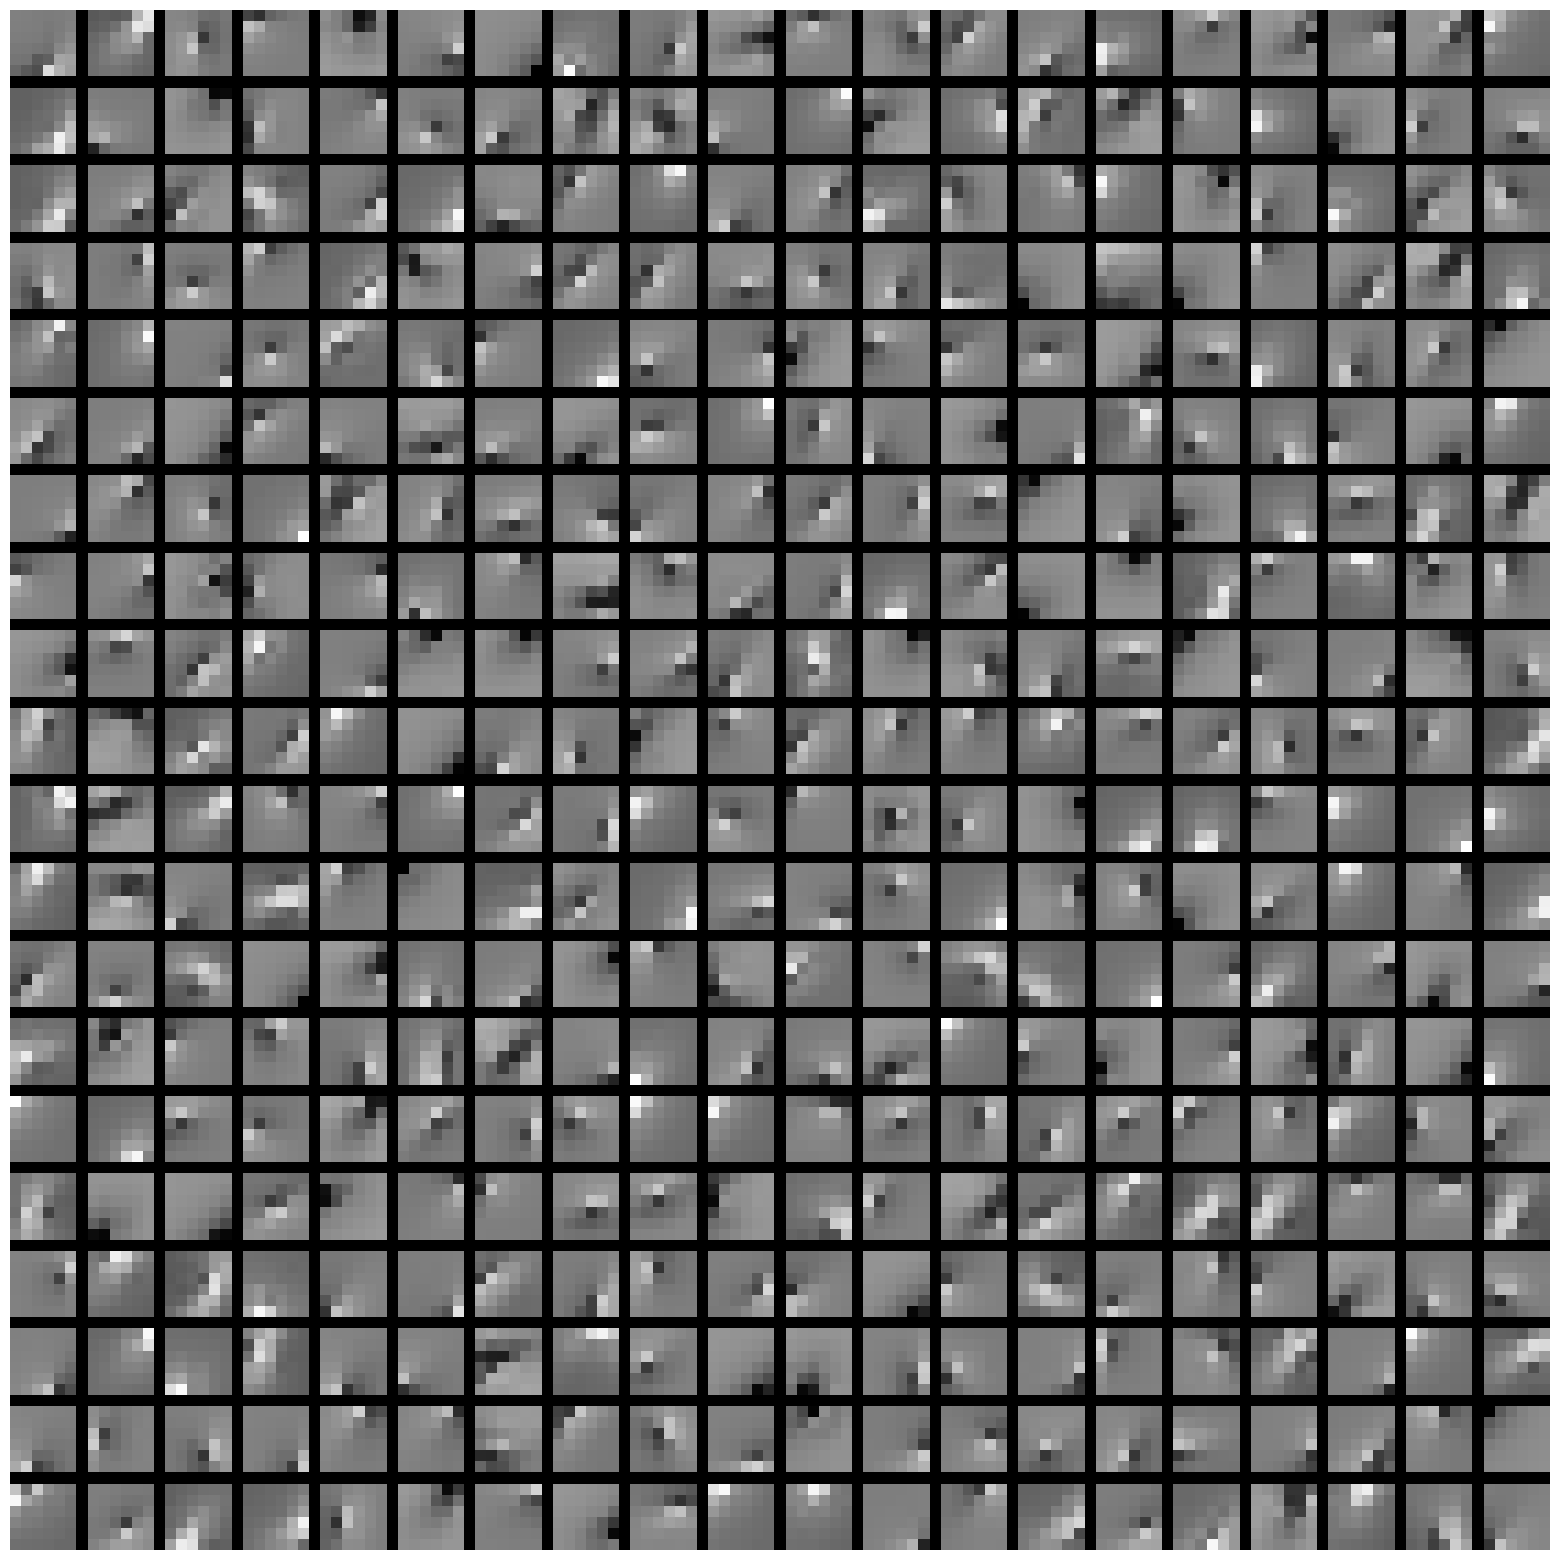

In [7]:
#Dictionary Visualization
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host,20,20,ax=ax,equal_contrast=True) #Visualize first 400 Dictionary Elements

image shape:  torch.Size([28, 28])
basis shape:  (36, 500)
patches.shape =  torch.Size([529, 36])


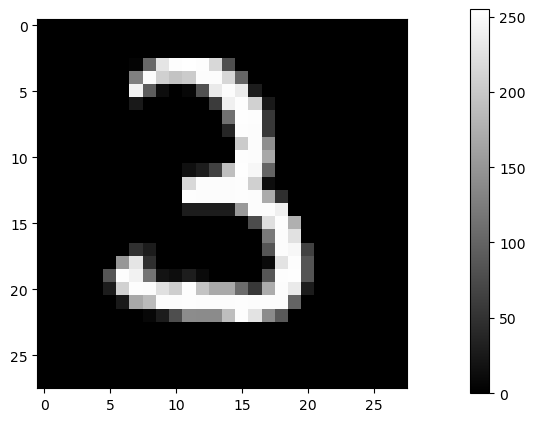

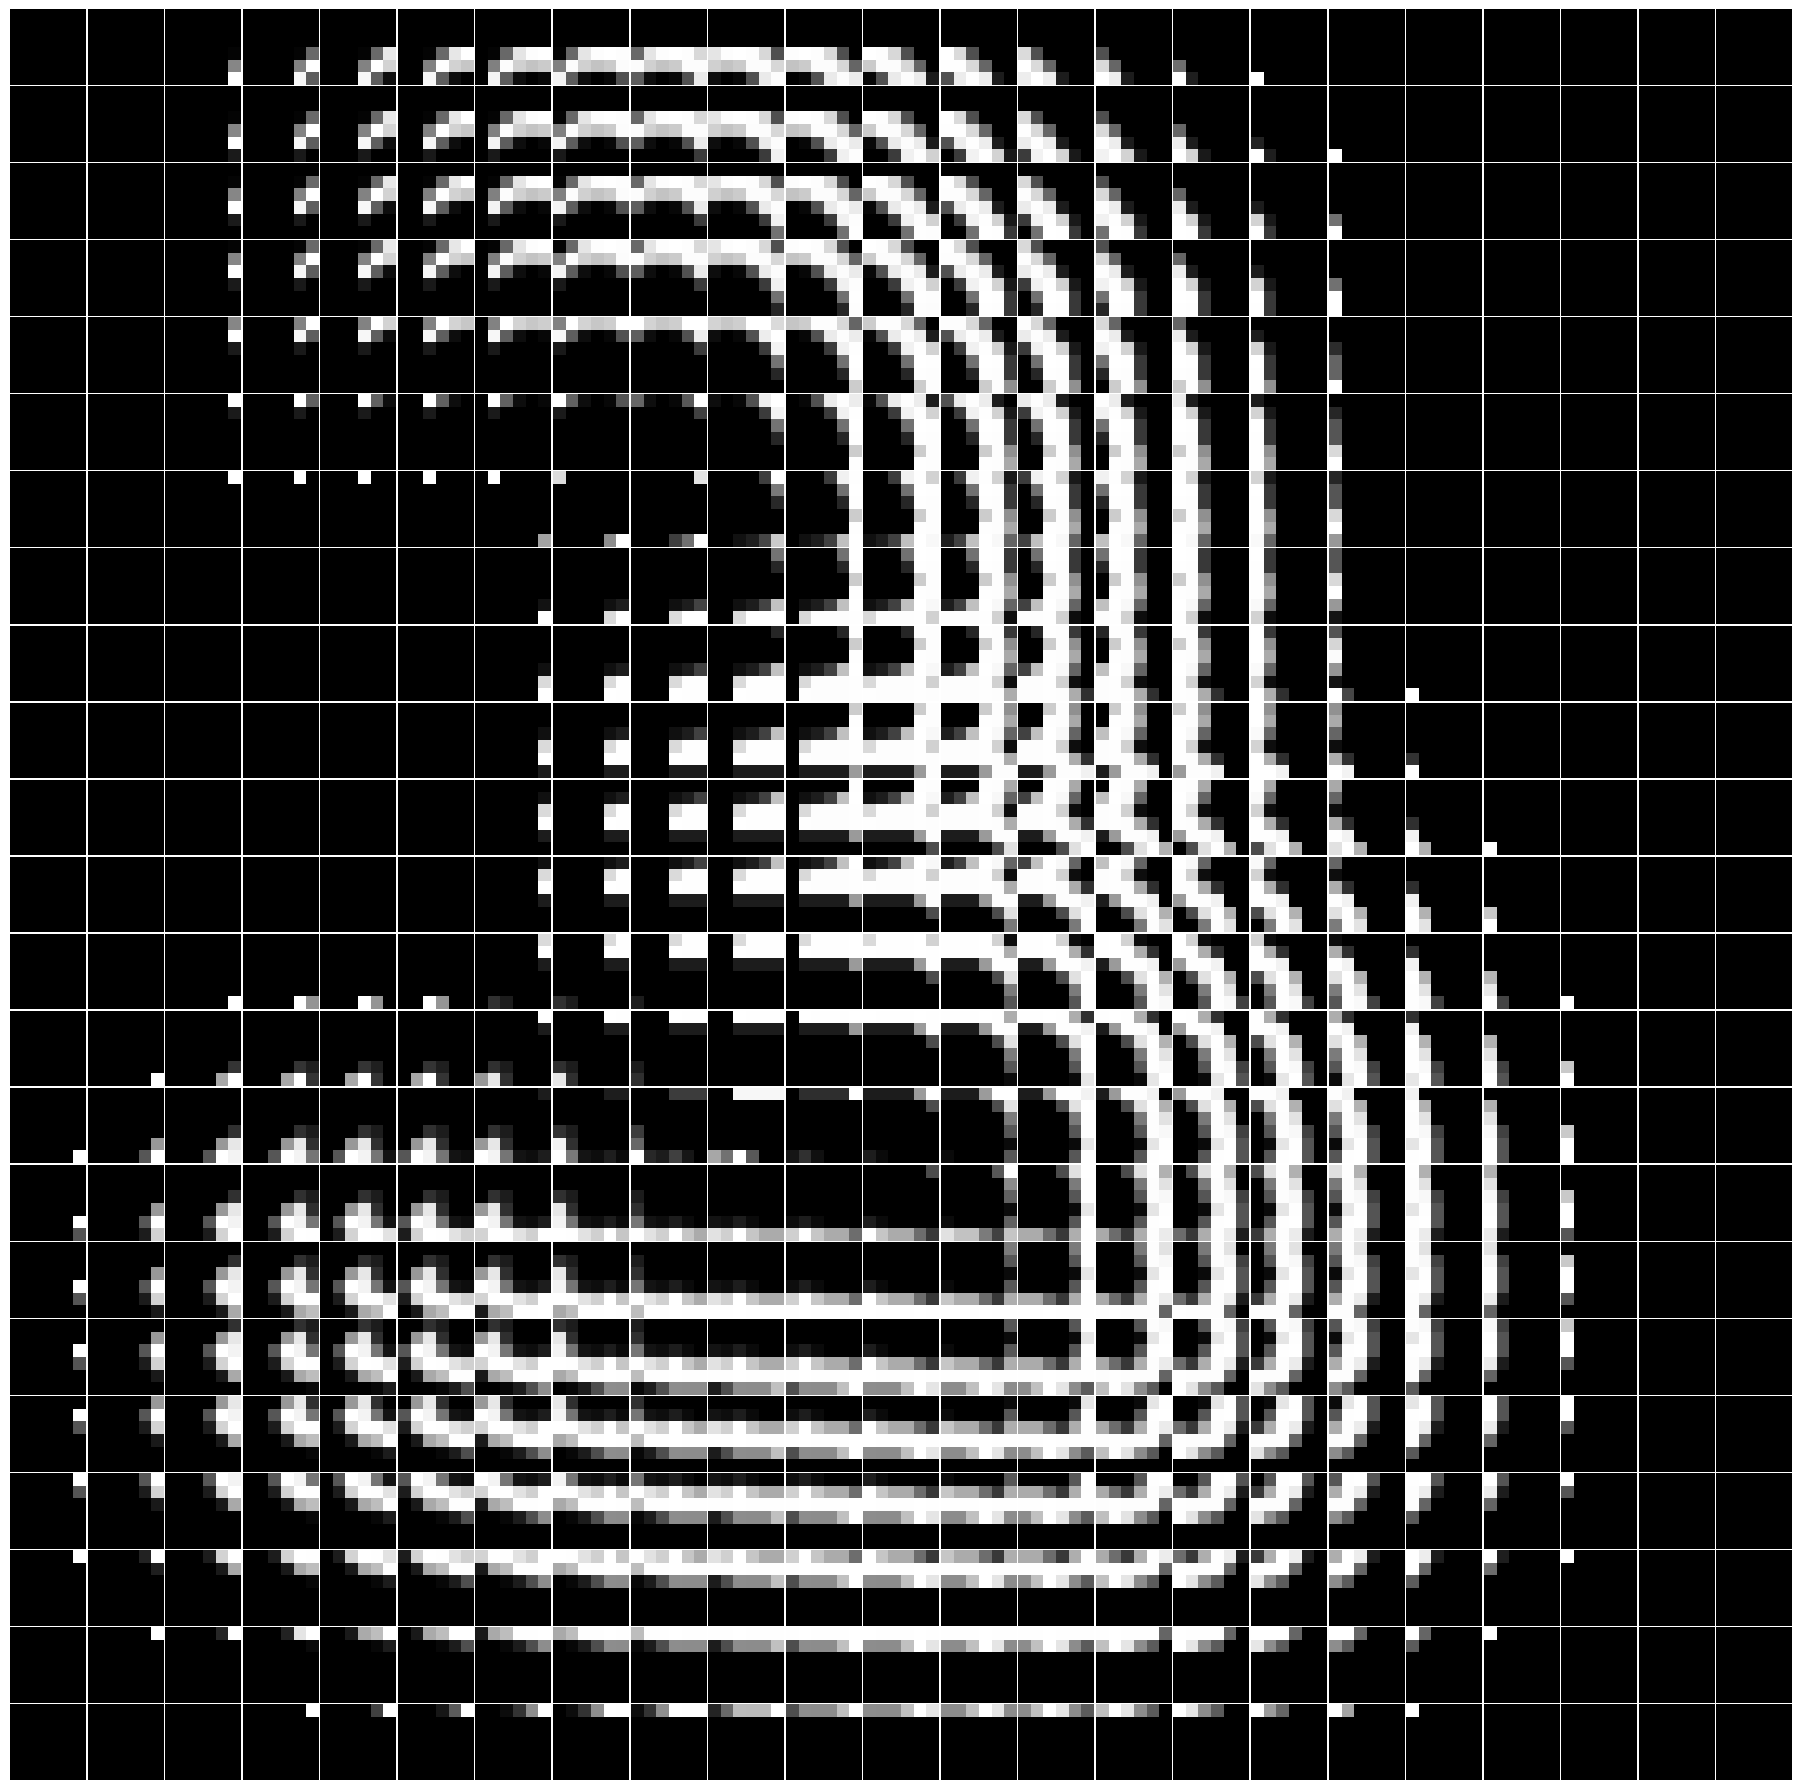

reconstructed patches shape:  torch.Size([529, 36])


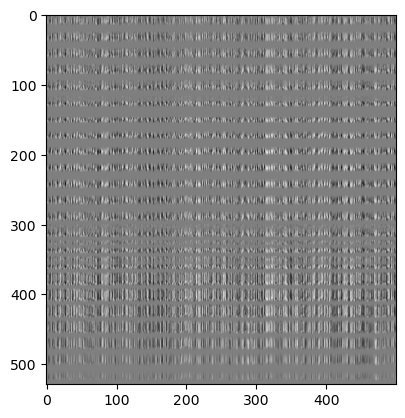

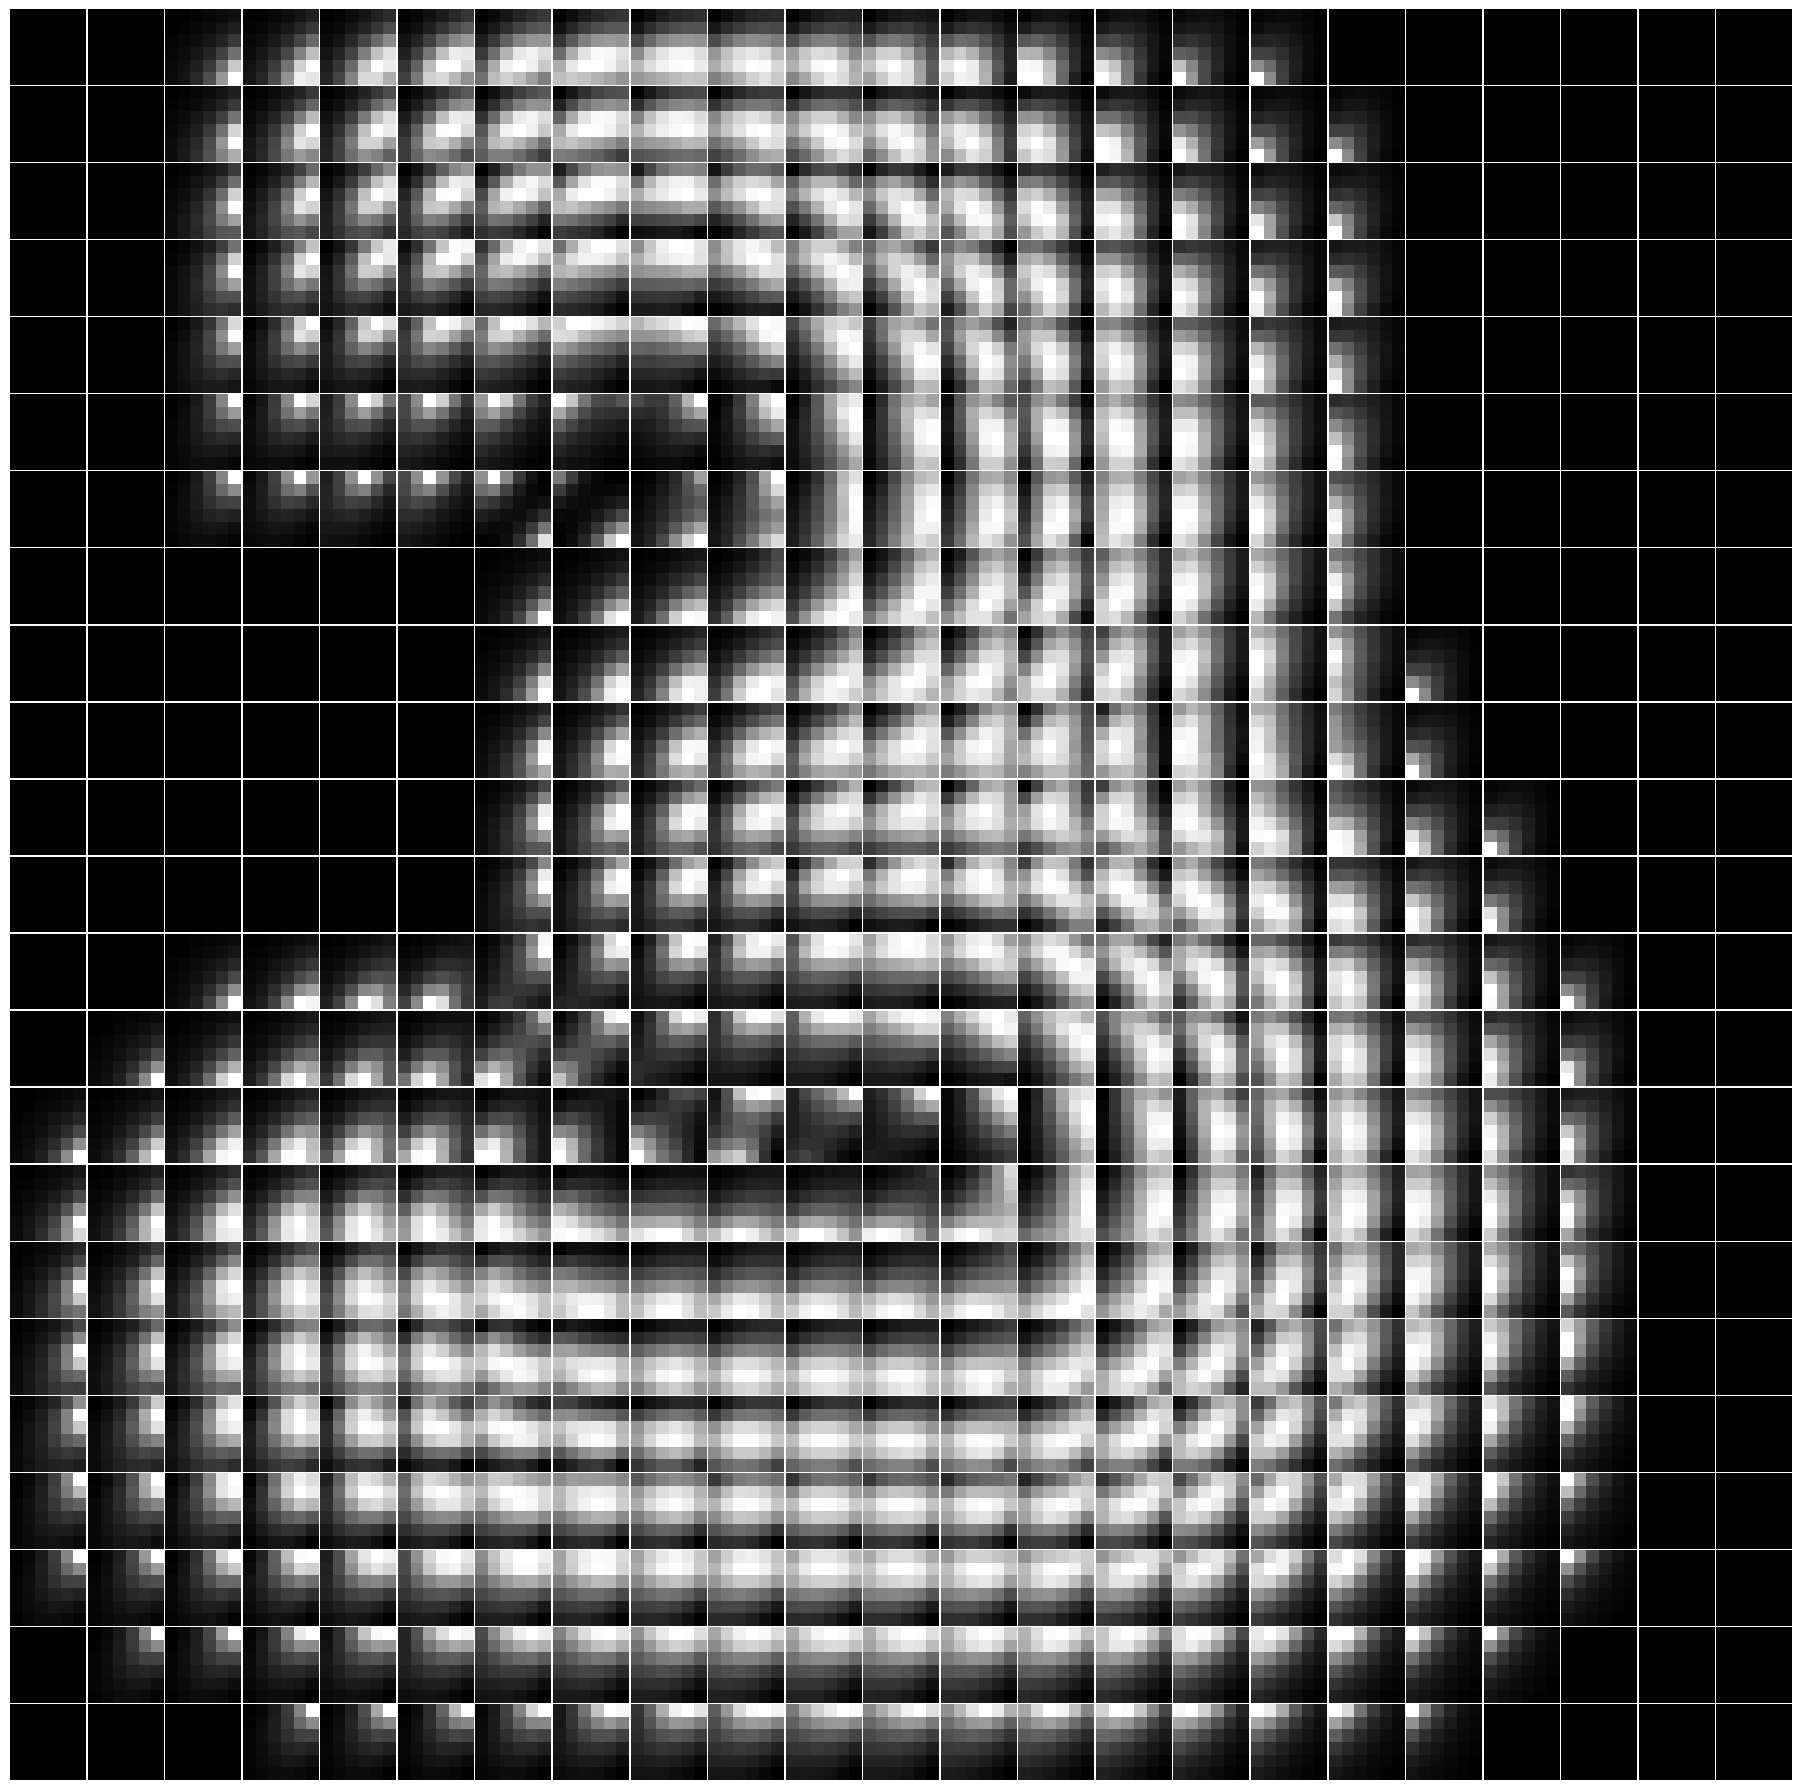

In [26]:
image_idx = 546
image = images[image_idx,:,:]
utility.imshow(image)

print("image shape: ", image.shape)

# find sparse code 
print("basis shape: ", basis1_host.shape)

Orig_Patches = utility.Image2Patch(image, patch_size=xdim, plot=True)


## Encode patches
Activities = Orig_Patches @ basis1_host
plt.figure()
plt.imshow(Activities, cmap="gray")


## Reconstruct
Recon_Patches = Activities @ basis1_host.T
print("reconstructed patches shape: ", Recon_Patches.shape)

col = 28 - xdim + 1
figure = plt.figure(figsize=(col, col))
for i in range(1, col * col + 1):
    figure.add_subplot(col, col, i)
    plt.axis("off")
    plt.imshow(Recon_Patches[i - 1].view(xdim, xdim), cmap="gray")

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()